<a href="https://colab.research.google.com/github/yestrella14/DS-Unit-2-Kaggle-Challenge/blob/master/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [ ]:
#Store id column for later
test_id = test['id']
test_id

0        50785
1        51630
2        17168
3        45559
4        49871
         ...  
14353    39307
14354    18990
14355    28749
14356    33492
14357    68707
Name: id, Length: 14358, dtype: int64

In [ ]:
import numpy as np

def wrangle(X):
  """Wrangle Train, Validate and test sets in the same way"""

  #prevent setting with copy
  X=X.copy()

  #lets treat the latitude with value almost zero to be equal to zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  #Replace 0s with null and inpute later
  #Create a "missing indicator" column, because the fact that
  # values are missing may be a predictive signal.
  cols_with_zeros=['longitude', 'latitude', 'population', 'gps_height', 'population', 'construction_year', 'num_private']
  for col in cols_with_zeros:
    X[col] =X[col].replace(0, np.nan)
    X[col+'_Missing']=X[col].isnull()
  
  #Drop the duplicated quanty_group column
  X = X.drop(columns=['quantity_group', 'waterpoint_type_group', 'source_type',
             'payment_type', 'extraction_type_group', 'extraction_type_class', 'scheme_name'])

  #Drop unsusuable variables
  unusuable = ['recorded_by', 'id']
  X=X.drop(columns=unusuable)

  # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
  # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  # Engineer feature: how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  return X

In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
test=wrangle(test)
train=wrangle(train)


In [ ]:

target='status_group'
features= train.columns.drop(['status_group'])
features=features

In [ ]:
X_train= train[features]
y_train =train[target]

In [ ]:
# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(),
                      RandomForestClassifier(n_estimators=50,
                                             n_jobs =-1,
                                             random_state=42))

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_class',
                                      'waterpoint_type'],
                                drop_invariant=F...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                    

In [ ]:
print('Training Accuracy', model.score(X_train, y_train))
print('Validation Accuracu: ', model.score(X_val, y_val))

Training Accuracy 0.9997053872053872
Validation Accuracu:  0.8096801346801347


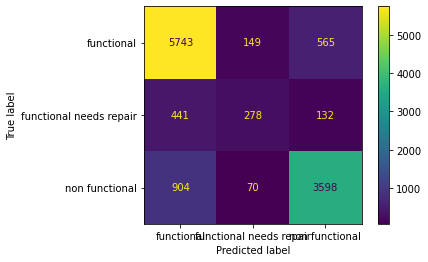

In [ ]:
plot_confusion_matrix(model, X_val, y_val,
                      values_format='.0f');

In [ ]:
print(classification_report(y_val, model.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6457
functional needs repair       0.56      0.33      0.41       851
         non functional       0.84      0.79      0.81      4572

               accuracy                           0.81     11880
              macro avg       0.74      0.67      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



In [20]:
X_test=test[features]

In [21]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [22]:
my_submission = pd.DataFrame(y_pred, columns=['status_group'])
my_submission['id']=test_id
my_submission.head()

,status_group,id
0,functional,50785
1,functional,51630
2,functional,17168
3,non functional,45559
4,functional,49871


In [23]:
my_submission.to_csv('YeraldinaSubmission4',index=False)